# Чем проблематичен CTR

Итак, мы научились генерировать CTR и увидели, насколько сложнее механихм его генерации по сравнению с конверсией. Но будет ли это проблемой для t-теста? Мы же видели, насколько он хорош для конверсии, неужели какой-то поганый CTR будет для него проблемой?

Давайте поглядим на это своими глазами.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.auto import tqdm

Возьмём функции для генерации выборок из прошлого ноутбука:

In [2]:
def generate_ctr_agg(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем количество поставленных лайков каждым пользователем
    likes = rng.binomial(n=views, p=p_likes, size=n)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))

In [3]:
def generate_ctr_raw(rng, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, multiplier=1.0):

    #генерируем вероятности просмотров
    p_views=rng.beta(a=a_views, b=b_views, size=n)
    #генерируем вероятности лайков (и делаем мультипликативный сдвиг)
    p_likes=rng.beta(a=a_likes, b=b_likes, size=n) * multiplier

    #генерируем количество просмотренных постов каждым пользователем
    views = rng.binomial(n=total_posts, p=p_views, size=n)
    #генерируем событие лайка-нелайка для каждого пользователя
    likes = np.concatenate([rng.binomial(n=1, p=p, size=size) for p, size in zip(p_likes, views)])

    #айдишники пользователей
    user_ids = np.arange(0, n, 1)
    #повторяем каждый, чтобы соответствовало событиям
    user_ids = np.repeat(user_ids, views)

    #возвращаем датафрейм
    return(pd.DataFrame({"user":user_ids, "is_liked":likes}))

## CTR и обычный t-тест

Сделаем всё то же, что сделали с конверсией - создадим функцию, где многократно симулируются данные, сравниваются с помощью t-теста, а полученные p-value сравниваются с порогом и сохраняются. 

In [8]:
def t_fpr_naive(n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000):

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = generate_ctr_raw(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_raw(rng, n=n, total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes) #данные тестовой группы

        #используем t-тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.ttest_ind(control.is_liked, test.is_liked, equal_var=False).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Проверим, насколько хорошо t-тест контролирует ошибку I рода! Напоминаю, что полученный график должен скакать в районе 0.05 - т.е. тест должен ошибаться примерно в 5% случаев при уровне значимости 0.05. 

In [9]:
t_naive_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_naive_fpr.append(t_fpr_naive(n=sample_size))

  0%|          | 0/54 [00:00<?, ?it/s]

<Axes: xlabel='Sample', ylabel='FPR'>

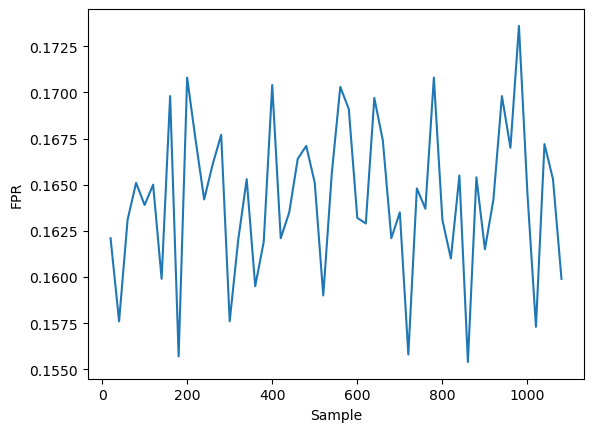

In [10]:
t_naive_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":t_naive_fpr})
sns.lineplot(data=t_naive_fpr_results, x="Sample", y="FPR")

Ой-ой. Вероятность ошибки I рода увеличилась больше чем в 3 раза! Это для нас плохие новости: это значит, что t-тест плохо контролирует ошибку I рода и мы будем чаще находить несуществующие различия между группами. А значит, этот тест нам не подойдёт.

Из-за чего это случилось? Чем именно проштрафился t-тест? Давайте переберём возможных виновников:

* **Размер выборки** - может, данных недостаточно? Но если бы контроль ошибки I рода от этого зависел, мы бы увидели постепенное снижение на графике - а он у нас явно равномерен. Значит, размер выборки с этим не связан.
* **Не работает центральная предельная теорема** - может, распределение выборочных CTR не нормально и поэтому невалидно самое критическое допущение t-теста? Это можно проверить симуляцией и посмотреть, какой формой обладает различие в CTR:

In [5]:
ctrs = [] #сюда будем складывать CTR

for _ in tqdm(range(10000)):

    control = generate_ctr_raw(np.random.default_rng()) #данные контрольной группы
    test = generate_ctr_raw(np.random.default_rng()) #данные тестовой группы
    
    #сохраняем разницу в ctr
    ctrs.append(control.is_liked.mean() - test.is_liked.mean())

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: ylabel='Count'>

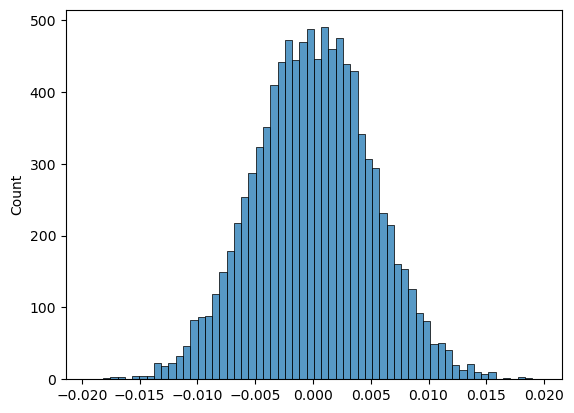

In [6]:
sns.histplot(ctrs)

Выглядит как прекрасное нормальное распределение, t-тест такие каждый день на обед ест. Значит, с этим допущением тоже ничего дурного нет.

* **Среднее не подходит для оценки CTR** - может, CTR просто нельзя считать с помощью среднего? Это очевидно не так, но давайте чисто ради интереса убедимся.

In [7]:
dat = generate_ctr_raw(np.random.default_rng(2112)) #генерируем данные

likes_sum = dat.is_liked.sum() #количество лайков - так как лайк 1, а нелайк 0, то сумма даст нам что нужно
views_sum = dat.is_liked.count() #количество просмотров - просто все строчки датафрейма

print(f"CTR через отношение лайков к просмотрам: {likes_sum/views_sum}")
print(f"CTR через расчёт среднего: {dat.is_liked.mean()}")

CTR через отношение лайков к просмотрам: 0.20435151858292555
CTR через расчёт среднего: 0.20435151858292555


Результат идентичен, как видите. Значит, с использованием среднего ничего дурного нет.

* **Стандартные ошибки неверные** - может, мы неверно оцениваем дисперсию в данных, а соответственно, и стандартную ошибку? В таком случае у нас легко может получиться некорректное p-value!

Проверить это несложно. Выше мы как раз посчитали распределение выборочных CTR - стандартное отклонение даст нам стандартную ошибку CTR. Ну а для стандартной ошибки, используемой в t-тесте, достаточно вспомнить формулу t-статистики:

$$t = \frac{\bar{X}_A - \bar{X}_B}{\sqrt{\frac{s_A^2}{n_A} + \frac{s_B^2}{n_B}}}$$

Нас интересует в данном случае знаменатель:

$$\sqrt{\frac{s_A^2}{n_A} + \frac{s_B^2}{n_B}}$$

$s_A^2$ и $s_B^2$ - это выборочные дисперсии групп, $n_A$ и $n_B$ - их размеры. Фигня вопрос, посчитаем. 

Давайте для начала глянем на стандартную ошибку в результате симуляции:

In [9]:
print(f"Стандартная ошибка в симуляции: {np.std(ctrs)}")

Стандартная ошибка в симуляции: 0.005084977598959147


Неплохо. А теперь давайте посчитаем, где будут находиться станадртные ошибки, если оценивать их по формуле из t-теста:

In [10]:
ses = [] #сюда будем складывать стандартные ошибки

for _ in tqdm(range(10000)):

    control = generate_ctr_raw(np.random.default_rng()) #данные контрольной группы
    test = generate_ctr_raw(np.random.default_rng()) #данные тестовой группы

    #стандартные ошибки в квадрате
    var_c = control.is_liked.var() / control.is_liked.count() 
    var_t = test.is_liked.var() / test.is_liked.count()
    
    #сохраняем общую стандартную ошибку
    ses.append(np.sqrt(var_c + var_t))

  0%|          | 0/10000 [00:00<?, ?it/s]

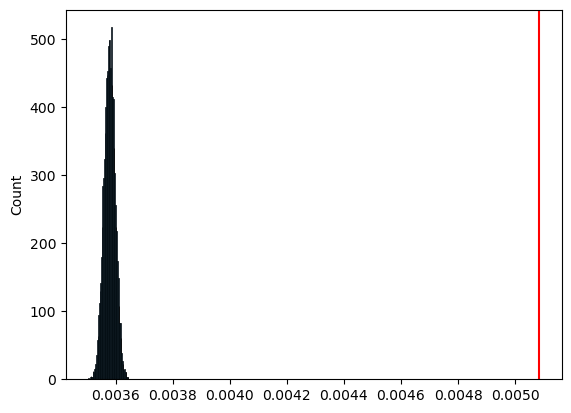

In [11]:
ax = sns.histplot(ses)
ax.axvline(x=np.std(ctrs), color="r") #красной линией пометим реальную стандартную ошибку

Ой-ой (2). Кажется, стандартная ошибка намного ниже той, которая должна быть - диапазоны даже не пересекаются! Неудивительно, что у нас вероятность ошибки I рода завышена; чем меньше стандартная ошибка, тем меньше p-value, а чем меньше p-value - тем вероятнее, что оно пересечёт порог значимости. Вот мы и нашли место, в котором t-тест ошибается.

Но почему так? Что именно не учитывает наш расчёт? И вот тут из кустов вылезает самый что ни на есть демонический рояль - **зависимые наблюдения**. Помните ведь, что один и тот же пользователь даёт нам несколько просмотров и несколько лайков?

Давайте разберёмся, почему это проблема - чисто интуитивно.

1. Цель любого статистического исследования - сделать некоторое суждение о генеральной совокупности. Чем больше самых разных наблюдений мы наберём - тем точнее будет наш вывод.
2. Когда мы собираем наблюдения одного и того же человека, мы делаем всё более точные суждения именно об этом человеке. Однако это не транслируется напрямую в более точные суждения о генеральной совокупности - конкретный пользователь наверняка будет отклоняться в своих показателях от среднего.
3. Соответственно, когда мы собираем множественные наблюдения от нескольких пользователей, то эти наблюдения неравноценны. Наблюдения от разных людей приближают нас к истине быстрее, чем наблюдения от одного и того же человека. Если собрать по одному наблюдению от 40 человек, то наш вывод будет точнее, чем если мы соберём по 10 наблюдений от 4 человек.
4. Наша оценка дисперсии и, соответственно, стандартной ошибки не знает об этой неравноценности. В результате стандартная ошибка оказываются ниже нужной, так как переоценивается степень точности нашего вывода.

Ну и что делать в таком случае? Об правильных подходах к вопросу будет в следующих ноутбуках, а пока покажу самый очевидный вариант решения проблемы. Который, к сожалению, тоже неправильный, но иначе.

## Пользовательские CTR

Самый простой способ разделаться с проблемой выше - посчитать CTR на каждого конкретного пользователя. В конце концов, у каждого пользователя потенциально несколько просмотров и несколько лайков - значит, и CTR для него мы посчитать можем. После этого остаётся только посчитать средние и сравнить их t-тестом.

Вот для этого я и включал расчёт этой метрики в функцию для генерации данных:

In [12]:
generate_ctr_agg(np.random.default_rng(2112))

,user,views,likes,user_ctr
0,0,30,4,0.133333
1,1,34,4,0.117647
2,2,19,4,0.210526
3,3,19,8,0.421053
4,4,21,3,0.142857
...,...,...,...,...
995,995,25,0,0.000000
996,996,27,9,0.333333
997,997,20,4,0.200000
998,998,16,3,0.187500


Поехали по классике.

In [13]:
def t_power_uneq(test_prop=1.0, n=1000, total_posts=50, a_views=10, b_views=10, a_likes=5, b_likes=20, alpha=0.05, num_iter=10000, test_multiplier=1.0):

    pvals = [] #сюда мы будем складывать результаты применения теста (значимо-незначимо)
    rng = np.random.default_rng() #генератор случайных чисел

    #повторяем процедуру несколько раз
    for _ in range(num_iter):

        control = generate_ctr_agg(rng, n=n, total_posts=total_posts, 
                                   a_views=a_views, b_views=b_views, 
                                   a_likes=a_likes, b_likes=b_likes) #данные контрольной группы
        test = generate_ctr_agg(rng, n=int(n*test_prop), total_posts=total_posts, 
                                a_views=a_views, b_views=b_views, 
                                a_likes=a_likes, b_likes=b_likes, multiplier=test_multiplier) #данные тестовой группы

        #используем t-тест, извлекаем p-value
        #сравниваем его с alpha и результат сохраняем в список pvals
        pvals.append(st.ttest_ind(control.user_ctr, test.user_ctr, equal_var=False).pvalue < alpha)

    #и считаем, какую долю от общего количества значений составляют True
    #можно посчитать сумму True и поделить на длину списка
    #а можно просто посчитать среднее, это математически эквивалентно
    return(np.mean(pvals))

Смотрим на FPR:

In [14]:
t_user_fpr = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_user_fpr.append(t_power_uneq(n=sample_size))

  0%|          | 0/54 [00:00<?, ?it/s]

C:\Users\allom\AppData\Local\Temp\ipykernel_21364\2115782487.py:14: RuntimeWarning: invalid value encountered in divide
  return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))


<Axes: xlabel='Sample', ylabel='FPR'>

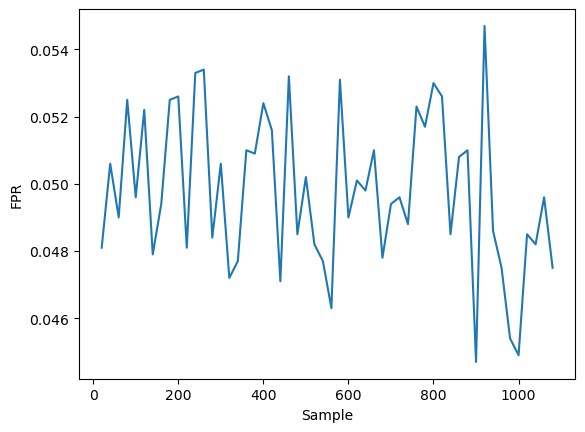

In [15]:
t_user_fpr_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "FPR":t_user_fpr})
sns.lineplot(data=t_user_fpr_results, x="Sample", y="FPR")

Вот теперь всё по красоте! T-тест контролирует ошибку I рода как надо.

Посмотрим на то, насколько он хорош при непропорциональных выборках:

In [17]:
t_user_fpr_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_user_fpr_uneq.append(t_power_uneq(n=1000, test_prop=prop))

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\allom\AppData\Local\Temp\ipykernel_21364\2115782487.py:14: RuntimeWarning: invalid value encountered in divide
  return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))


<Axes: xlabel='Proportion', ylabel='FPR'>

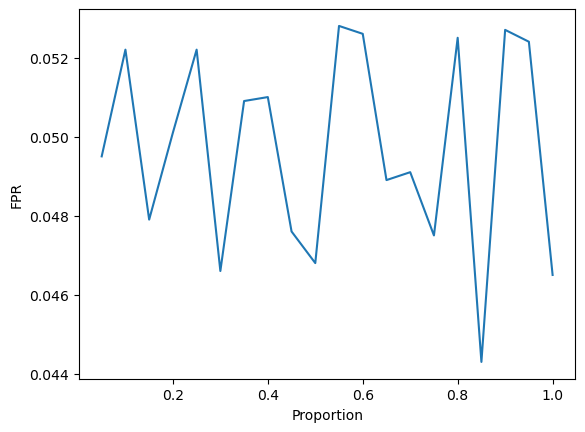

In [19]:
t_user_fpr_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "FPR":t_user_fpr_uneq})
sns.lineplot(data=t_user_fpr_uneq_results, x="Proportion", y="FPR")

Всё ещё неплохо! Справляется лучше, чем с конверсией, кстати - можете помнить, что ошибка I рода при тестировании конверсии завышалась при сильной диспропорции в размерах выборки. Здесь такого нет.

Ну и чисто для проформы посмотрим на графики мощности:

In [25]:
t_user_power = []

for sample_size in tqdm(range(20, 1100, 20)):

    t_user_power.append(t_power_uneq(n=sample_size, test_multiplier=1.1))

  0%|          | 0/54 [00:00<?, ?it/s]

C:\Users\allom\AppData\Local\Temp\ipykernel_21364\2115782487.py:14: RuntimeWarning: invalid value encountered in divide
  return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))


<Axes: xlabel='Sample', ylabel='Power'>

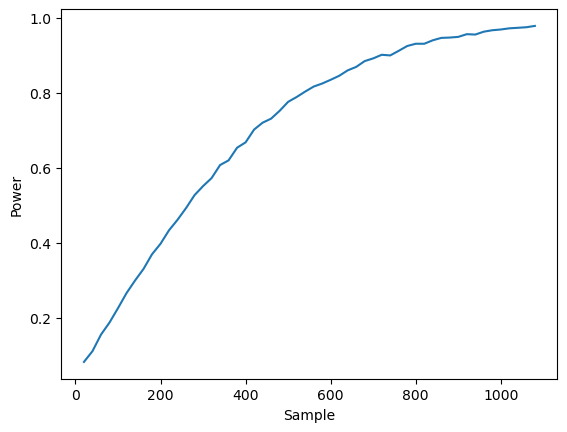

In [26]:
t_user_power_results = pd.DataFrame({"Sample":list(range(20, 1100, 20)), "Power":t_user_power})
sns.lineplot(data=t_user_power_results, x="Sample", y="Power")

Выглядит разумно. И для диспропорциональных выборок:

In [27]:
t_user_power_uneq = []

for prop in tqdm(np.arange(0.05, 1.05, 0.05)):

    t_user_power_uneq.append(t_power_uneq(n=1000, test_prop=prop, test_multiplier=1.1))

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\allom\AppData\Local\Temp\ipykernel_21364\2115782487.py:14: RuntimeWarning: invalid value encountered in divide
  return(pd.DataFrame({"user":np.arange(0, n, 1), "views":views, "likes":likes, "user_ctr":likes/views}))


<Axes: xlabel='Proportion', ylabel='Power'>

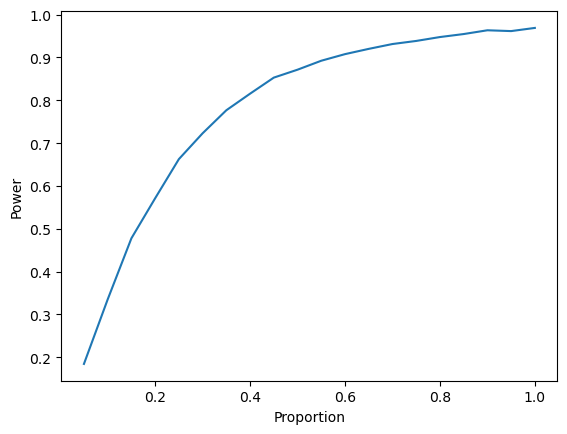

In [28]:
t_user_power_uneq_results = pd.DataFrame({"Proportion":np.arange(0.05, 1.05, 0.05), "Power":t_user_power_uneq})
sns.lineplot(data=t_user_power_uneq_results, x="Proportion", y="Power")

Опять же, всё как и ожидалось! Выглядит всё хорошо. Так почему же мы не можем использовать эту метрику для оценки различий в CTR?

Давайте посмотрим наглядно. Сгенерируем данные:

In [13]:
dat = generate_ctr_agg(np.random.default_rng(seed=2112))

Сравним настоящий CTR и средний пользовательский CTR:

In [15]:
print(f"CTR: {dat.likes.sum() / dat.views.sum()}")
print(f"Средний пользовательский CTR: {dat.user_ctr.mean()}")

CTR: 0.2039875439802645
Средний пользовательский CTR: 0.20237186040880134


Ага. Можете видеть, что это две очень близкие, но всё-таки разные метрики! Но может, это не так плохо? Наверняка между ними есть хорошая корреляция!

Давайте это проверим и нагенерируем кучу разниц CTR и средних пользовательских CTR. После этого нарисуем диаграмму рассеяния:

In [16]:
diff_ctr = []
diff_user_ctr = []

rng = np.random.default_rng() #генератор случайных чисел

#повторяем процедуру несколько раз
for _ in tqdm(range(10000)):

    control = generate_ctr_agg(rng, n=20) #данные контрольной группы
    test = generate_ctr_agg(rng, multiplier=1.1, n=20) #данные тестовой группы

    diff_ctr.append((control.likes.sum() / control.views.sum()) - (test.likes.sum() / test.views.sum()))
    diff_user_ctr.append(control.user_ctr.mean() - test.user_ctr.mean())

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: >

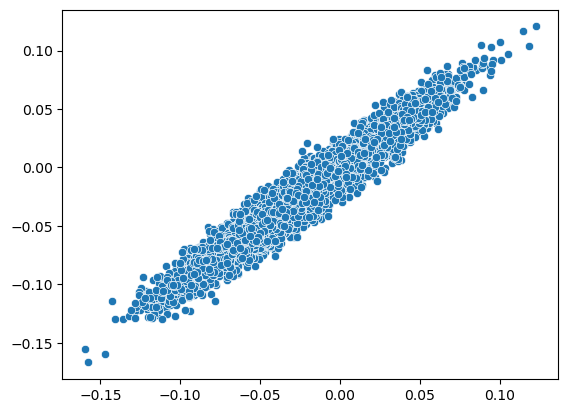

In [17]:
sns.scatterplot(x=diff_ctr, y=diff_user_ctr)

Ну что тут можно сказать? Корреляция действительно есть и довольно сильная. Однако она, к сожалению, не идеальная; средний пользовательский CTR может легко как превышать реальный CTR, так и быть ниже его. Это довольно сильно усложняет интерпретацию результатов и расчёты мощности теста для анализа метрики.

Однако хуже всего то, что у нас нет гарантии **сонаправленности метрик** - т.е что изменение между двумя CTR и двумя средними пользовательскими CTR будет иметь тот же знак. Давайте посмотрим на наличие таких кейсов:

In [20]:
print(f"Доля случаев, когда CTR вырос, а средний пользовательский CTR упал: {np.sum((np.array(diff_ctr) > 0) & (np.array(diff_user_ctr) < 0)) / 10000}")
print(f"Доля случаев, когда CTR упал, а средний пользовательский CTR вырос: {np.sum((np.array(diff_ctr) < 0) & (np.array(diff_user_ctr) > 0)) / 10000}")

Доля случаев, когда CTR вырос, а средний пользовательский CTR упал: 0.035
Доля случаев, когда CTR упал, а средний пользовательский CTR вырос: 0.0362


Суммарно процент обоих случаев составляет порядка 7. Готовы ли вы рискнуть тем, что ваш эксперимент попадёт в эти 7%? А ведь процент может быть и совсем другим - в зависимости от того, сколько у вас в среднем просмотров на пользователя.

Давайте попробуем ответить на вопрос: как у нас может получиться CTR в 0.5? Это может быть 500 лайков и 1000 просмотров; может быть 5 лайков и 10 просмотров; а может быть и 1 лайк и 2 просмотра. Вы наверняка будете вкладывать разную степень уверенности в эти результаты - однако чисто по CTR вы этого не увидите.

И для "глобального" CTR по всей выборке это не особо проблема: наверняка у нас будет довольно много просмотров и лайков, и оценка CTR будет достаточно стабильна. Однако в случае пользовательских CTR эта проблема встаёт в полный рост. При расчёте "глобального" CTR пользователь с 1 лайком и 2 просмотрами будет иметь минимальный эффект на результат - однако при расчёте среднего пользовательского CTR его вклад будет непропорционально велик. Как результат, наша оценка может очень сильно отличаться от истинной.

Логичный выход - считать свзвешенные средние, где больший вес будет даваться пользовательским CTR на основе большего числа событий. Но как это сделать корректно, чтобы это работало ок? Об этом, а также о корректной оценки дисперсии с зависимыми наблюдениями - в следующих сериях.